In [150]:
%matplotlib inline

In [151]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [154]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [155]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^-a-zA-Z.!?а-яёйЁА-Я]+", r" ", s)
    return s

In [156]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in lines if l !='']

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [159]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    if len(p)==2:
        return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)
    else:
        return False



def filterPairs(pairs):
    return [pair for pair in pairs  if filterPair(pair)]

In [160]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        if len(pair)==2:
            input_lang.addSentence(pair[0])
            output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(input_lang, '\n',output_lang, '\n',random.choice(pairs))#



Reading lines...
Read 479223 sentence pairs
Trimmed to 27844 sentence pairs
Counting words...
Counted words:
rus 10125
eng 4320
 ['я устал сидеть .', 'i m tired of sitting .']


The Encoder
-----------





In [163]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        #инициализация при создании объекта класса input_size==n_words, hidden_size=256(размер выходного вектора энкодера)
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        #self.gru = nn.LSTM(hidden_size, hidden_size,num_layers=2)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        #получили одно слово(тензор(-1,1)) из фразы в энкодер ==input_tensor[ei] и hidden==encoder_hidden = encoder.initHidden()
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
        #return torch.zeros(2, 1, self.hidden_size, device=device),torch.zeros(2, 1, self.hidden_size, device=device)

AttnDecoderRNN
---

In [174]:

class MLP_AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(MLP_AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dotprod=nn.CosineSimilarity(dim=1)
        #self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        #self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.v = nn.Linear(self.hidden_size, 1, bias = False)


        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        #embedded = self.dropout(embedded)

        #hidden_shape==[1,1,hidden_size]
        #encoder_outputs_shape=[max_length,hidden_size]
        loc_tens = hidden.squeeze(0).repeat(self.max_length,1)
        
        energy = torch.tanh(self.attn(torch.cat((loc_tens, encoder_outputs), dim = 1))) 

        attention = self.v(energy).squeeze(1)
        
        attention = F.softmax(attention, dim=0)

        #attention = self.dotprod(encoder_outputs,loc_tens)
        #attention = attention.softmax(0)
        
        # получили вектор косинусного сходства(hidden vs encoder_outputs),  длиной == кол-ву слов в фразе 
        # и умножаем векторы из encoder_outputs-матрицы на соответствующую компоненту из вектора attention 
        attn_applied = attention*encoder_outputs.permute(1,0)

        attn_applied=attn_applied.T
        
        attn_applied=attn_applied.sum(0)
        # потом складываем вектора из encoder_outputs-матрицы в один и конкатенируем его с embedded вектором 
        
        # получаем вектор длиной 2*self.hidden_size
        output = torch.cat((embedded.squeeze(), attn_applied), 0)
        output=self.dropout(output)
        output = self.attn_combine(output).view(1, 1, -1)

        #output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attention

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [175]:
class DotAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(DotAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dotprod=nn.CosineSimilarity(dim=1)
        #self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        #embedded = self.dropout(embedded)
        #hiddensize==[1,1,-1]
        loc_tens = hidden.squeeze(0).repeat(self.max_length,1)

        '''cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        output = cos(my_att, torch.ones(10,5))
        output=output.softmax(0)'''

        attention = self.dotprod(encoder_outputs,loc_tens)
        attention = attention.softmax(0)
        
        # получили вектор косинусного сходства(hidden vs encoder_outputs),  длиной == кол-ву слов в фразе 
        # и умножаем векторы из encoder_outputs-матрицы на соответствующую компоненту из вектора attention 
        attn_applied = attention*encoder_outputs.permute(1,0)

        attn_applied=attn_applied.T
        
        attn_applied=attn_applied.sum(0)
        # потом складываем вектора из encoder_outputs-матрицы в один и конкатенируем его с embedded вектором 
        
        # получаем вектор длиной 2*self.hidden_size
        output = torch.cat((embedded.squeeze(), attn_applied), 0)
        output=self.dropout(output)
        output = self.attn_combine(output).view(1, 1, -1)

        #output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attention

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [177]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    #из фразы получаем тензор размерности [-1,1], где вместо -1 будет количество индексов слов из словаря
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [181]:
teacher_forcing_ratio = 0.5

#input_tensor и target_tensor тензоры из индексов слов во входной и выходной фразах size==(-1,1) где в -1 - индексы слов из словаря
# где -1 - размерность == max_length=MAX_LENGTH==10
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)  # размер input_tensor и target_tensor имеет право быть разным!
    target_length = target_tensor.size(0)# размер input_tensor и target_tensor имеет право быть разным!

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        #подаём одно слово(т.е его индекс) из фразы(одно число из тензора) в энкодер ==input_tensor[ei]
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        #получаем выход == output, hidden = self.gru(output, hidden)

        encoder_outputs[ei] = encoder_output[0, 0] # или encoder_output.squeeze()

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden,dec_attn= decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden,dec_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [182]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [183]:
'''tensorsFromPair(random.choice(pairs))[0][3,0]'''

'tensorsFromPair(random.choice(pairs))[0][3,0]'

In [184]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

    plt.title('Лосс', fontsize=15)

    '''plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)'''
    plt.legend()

    plt.show()

In [185]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    #получили список кортежей вх. и вых. фраз в виде тензоров (-1,1) где -1 - индексы слов из словаря
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]#   вх. фраз в виде тензоров (-1,1) где -1 - индексы слов из словаря
        target_tensor = training_pair[1]# вых. фраз в виде тензоров (-1,1) где -1 - индексы слов из словаря

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [187]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden ,dec_attn= decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [188]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [191]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_DotProduct = DotAttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
decoder_MLP = MLP_AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
#decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

5m 23s (- 48m 35s) (7500 10%) 2.9483
10m 45s (- 43m 0s) (15000 20%) 2.4254
16m 28s (- 38m 26s) (22500 30%) 2.1403
22m 56s (- 34m 24s) (30000 40%) 1.9063
29m 21s (- 29m 21s) (37500 50%) 1.7888
35m 50s (- 23m 53s) (45000 60%) 1.6602
42m 10s (- 18m 4s) (52500 70%) 1.5735
48m 39s (- 12m 9s) (60000 80%) 1.4804
55m 6s (- 6m 7s) (67500 90%) 1.4147


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


61m 37s (- 0m 0s) (75000 100%) 1.3599


<Figure size 640x480 with 0 Axes>

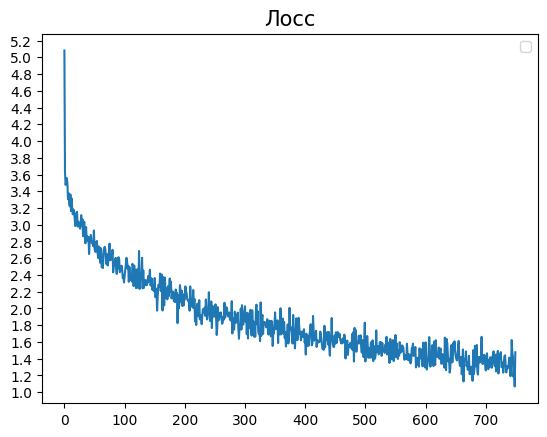

In [192]:
trainIters(encoder1, decoder_DotProduct, 75000, print_every=7500)

In [193]:
evaluateRandomly(encoder1, decoder_DotProduct)

> я еще с тобои не закончил .
= i m not finished with you .
< i m not finished yet . <EOS>

> я очень занята том .
= i m really busy tom .
< i m very busy . <EOS>

> я начинаю жалеть об этом .
= i m beginning to regret it .
< i m beginning to give it . <EOS>

> она намного тяжелее его .
= she s much heavier than him .
< she is a than . . <EOS>

> я устал ходить .
= i am tired from walking .
< i m tired of <EOS>

> я очень горжусь этими парнями .
= i m really proud of those guys .
< i m very proud of . <EOS>

> ты не студент .
= you are not a student .
< you re not a student . <EOS>

> им повезло что они живы .
= they re lucky to be alive .
< they re lucky to be alive . <EOS>

> мы не по тои дороге идем .
= we aren t on the right road .
< we re not on the the . . <EOS>

> я рад слышать что вы говорите это .
= i m glad to hear you say that .
< i m glad to hear you . <EOS>



6m 22s (- 57m 24s) (7500 10%) 2.5486
12m 56s (- 51m 46s) (15000 20%) 1.9699
19m 29s (- 45m 29s) (22500 30%) 1.8063
26m 6s (- 39m 9s) (30000 40%) 1.7155
32m 44s (- 32m 44s) (37500 50%) 1.6809
39m 13s (- 26m 8s) (45000 60%) 1.6568
45m 43s (- 19m 35s) (52500 70%) 1.6393
52m 9s (- 13m 2s) (60000 80%) 1.6372
58m 38s (- 6m 30s) (67500 90%) 1.6923


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


65m 33s (- 0m 0s) (75000 100%) 1.6932


<Figure size 640x480 with 0 Axes>

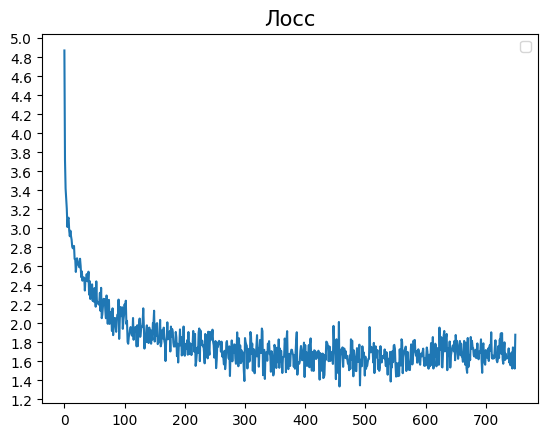

In [194]:
trainIters(encoder1, decoder_MLP, 75000, print_every=7500)

In [195]:
evaluateRandomly(encoder1, decoder_MLP)

> вы мне не мать .
= you re not my mom .
< you re not my mother . <EOS>

> вы такая странная .
= you re so weird .
< you re so a . <EOS>

> ты врач .
= you are a doctor .
< you re a doctor doctor . <EOS>

> я слегка голоден .
= i m a bit hungry .
< i m hungry hungry hungry hungry hungry hungry <EOS>

> я так рад что ты появился .
= i m so glad you showed up .
< i m so glad that you is . . .

> ты жалкая старуха .
= you re a mean old woman .
< you re a a a for . <EOS>

> она копит деньги чтобы поехать за границу .
= she is saving money to go abroad .
< she is very to he a <EOS>

> мне нехорошо .
= i m not well .
< i m no . <EOS>

> по профессии он зубнои врач .
= he is a dentist by profession .
< he is a doctor a a doctor doctor a .

> она слишком мала чтобы ходить в школу .
= she is too young to go to school .
< she too young to . <EOS>

